In [440]:
import h5py
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
#from scipy.fft import fftshift
from scipy.interpolate import CubicSpline
from pycbc.detector import Detector
from gwpy.timeseries import TimeSeries
from gwpy.detector import Channel

In [441]:
def ReadExtrapolatedMode(file, mode = (2,2), order = 2, mass = 68 * const.M_sun, radius = 400000 * const.kpc):
    """ Read in an extrapolated SXS-format gravitational waveform mode """

    l = mode[0]
    m = mode[1]
    f = h5py.File(file, 'r')
    data = f['Extrapolated_N'+str(order)+'.dir']['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    time = time - time[0]
    
    ## Combine the real and imaginary parts of the data
    re_adj = re*const.G*mass/((const.c)**2*radius)
    im_adj = im*const.G*mass/((const.c)**2*radius)
    time_adj = time*mass*const.G/(const.c**3)
    
    #dt = 1/len(time_adj)
     
    dt = 1/2048
    times = np.arange(time_adj[0].value, time_adj[-1].value, dt)
    cs_r = CubicSpline(time_adj,re_adj)
    cs_i = CubicSpline(time_adj,im_adj)
    
    real = cs_r(times)
    imag = cs_i(times)
    
    #return time, re, im, dt
    return times, real, imag, dt

def CutTimes(time, data, TLow, TUp): 
    TLowIndex = np.where(time <= TLow)[0][-1]
    TUpIndex = np.where(time >= TUp)[0][0]
    time = time[TLowIndex:TUpIndex]
    data = data[TLowIndex:TUpIndex]
    return time, data

def Ramp(time, t_s, t_r):
    if (time < t_s):
        return 0.0
    elif time > (t_s + t_r):
        return 1.0
    else:
        t = (time - t_s)/t_r
        return t**5*(126 + t*(-420 + t*(540 + t*(-315 + 70*t))))
    

In [442]:
# Please uncomment the line below and fill in the correct path
rh_file = "Waveforms_22/Lev2/rhOverM_Asymptotic_GeometricUnits_CoM.h5"
#rh_file = "SXS_0305/rhOverM_Asymptotic_GeometricUnits_CoM.h5"


# Open the HDF5 file in read-only mode:
rh_data = h5py.File(rh_file,'r')

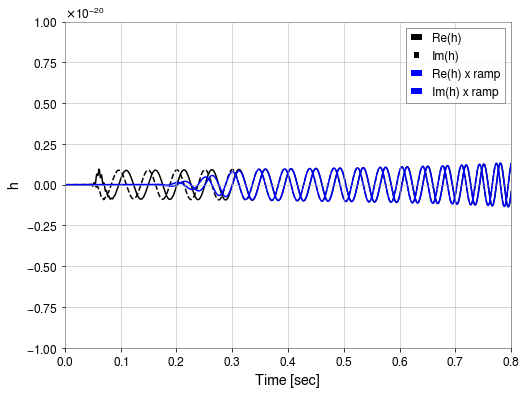

0.00048828125
2048


In [443]:
plt.figure(figsize=(8, 6))
t, re, img, dt = ReadExtrapolatedMode(rh_file, mode = (2,2), order = 2,  mass = 68 * const.M_sun)

ramp = np.array([Ramp(time, 200, 157.25) for time in t])
ramp = np.array([Ramp(time, 0.1, 0.3) for time in t])
#plt.plot(t, ramp, label='0.2 x Ramp function', color='red')
plt.plot(t, re, color='black', label='Re(h)')
plt.plot(t, img, '--', color='black', label='Im(h)')
plt.plot(t, re * ramp, color='blue', label='Re(h) x ramp')
plt.plot(t, img * ramp, color='blue', label='Im(h) x ramp')

#zero_crossings = np.where(np.diff(np.sign(re)))[0]
#print(zero_crossings)
#for i in zero_crossings:
#    plt.axvline(t[i])
#print(t[zero_crossings[2]] - t[zero_crossings[0]])
    
plt.xlim(0, 0.8)
plt.ylim(-1e-20, 1e-20)
plt.legend()
plt.xlabel('Time [sec]')
plt.ylabel('h')
plt.show()
print(dt)
print(int(1/dt))

## actually apply the ramp function
re = re * ramp
img = img * ramp

In [460]:
h_plus = re + img
h_cross = re - img

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

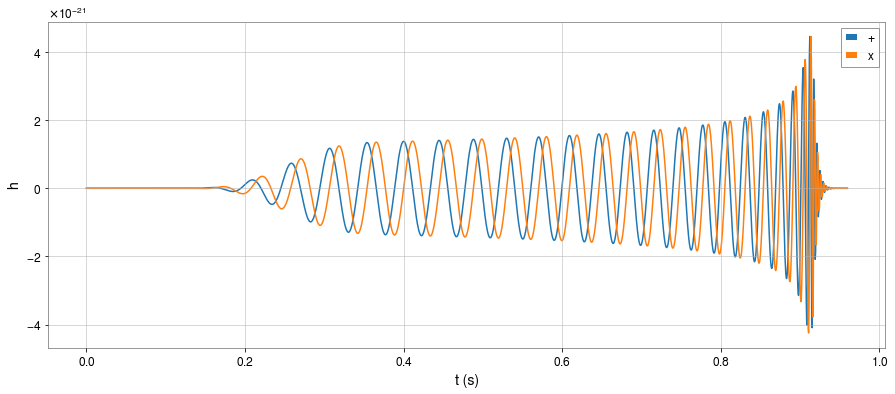

In [461]:
plt.figure(figsize = ([15, 6]))
plt.plot(t, h_plus, label = '+')
plt.plot(t, h_cross, label = 'x')
plt.xlabel('t (s)')
plt.ylabel('h')
plt.legend()
plt.plot


In [462]:
d_H1 = Detector("H1")
d_L1 = Detector("L1")

In [463]:
def ProjectToDetectors(ra, dec, pol, t0, plus, cross, time):
    '''
    ra - Right Ascension
    dec - Declination
    pol - Polarization Angle
    t0 - reference time for when signal reaches Hanford
    '''
    
    #Instantiating detector objects
    
    #The time delay of the signal between the detectors
    t_delay = d_L1.time_delay_from_detector(d_H1, ra, dec, t0)
    
    #Antenna Patterns
    Fp_H1, Fc_H1 = d_H1.antenna_pattern(ra, dec, pol, t0)
    Fp_L1, Fc_L1 = d_L1.antenna_pattern(ra, dec, pol, t0 + t_delay)
    
    #project
    h_H1 = Fp_H1*plus + Fc_H1*cross
    h_L1 = Fp_L1*plus + Fc_L1*cross
    
    #Shift times
    time_H1 = time
    time_L1 = time + t_delay
    
    return h_H1, h_L1, time_H1, time_L1

In [464]:
strainH, strainL, timeH, timeL = ProjectToDetectors(ra=4.7614763656, dec=-0.531780006467, pol=0.310886773011, \
                                                    t0=0, plus=h_plus, cross=h_cross, time=t)

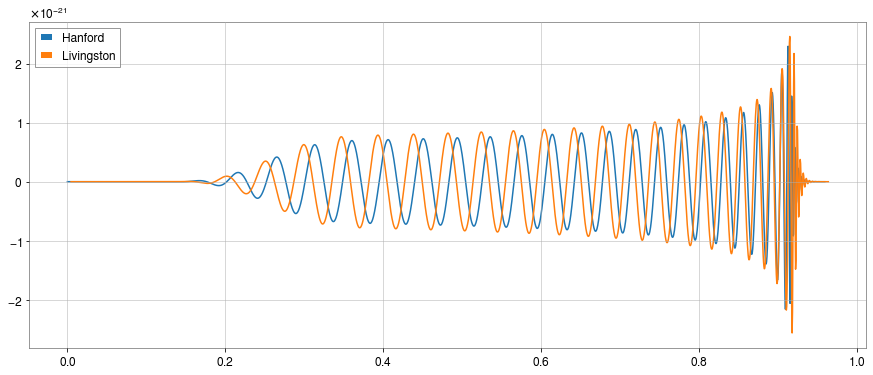

In [465]:
plt.figure(figsize = ([15, 6]))
plt.plot(timeH, strainH, label = "Hanford")
plt.plot(timeL, strainL, label = "Livingston")
plt.legend(loc = 2)
plt.show()

In [478]:
# Wrap these up as TimeSeries objects
# https://gwpy.github.io/docs/stable/timeseries/io.html

H1_data = TimeSeries(strainH,sample_rate=1/dt,epoch=timeH[0],channel="H1:LDAS_STRAIN")
L1_data = TimeSeries(strainL,sample_rate=1/dt,epoch=timeL[0],channel="L1:LDAS_STRAIN")

Zeroes = 0*np.arange(0., 8.0, dt)

H1_zeroes = TimeSeries(Zeroes,sample_rate=1/dt,epoch=timeH[0],channel='H1:LDAS_STRAIN')
L1_zeroes = TimeSeries(Zeroes,sample_rate=1/dt,epoch=timeL[0],channel="L1:LDAS_STRAIN")

In [479]:
L1_padded = L1_zeroes.inject(L1_data)
H1_padded = H1_zeroes.inject(H1_data)

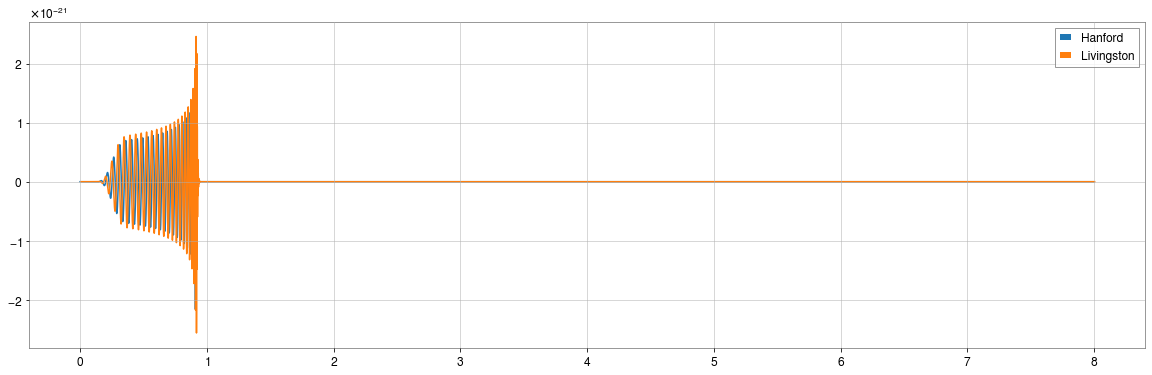

In [480]:
plt.figure(figsize = ([20, 6]))
plt.plot(H1_padded.times.value, H1_padded.value, label = 'Hanford')
plt.plot(L1_padded.times.value, L1_padded.value, label = 'Livingston')
plt.legend()
plt.show()

In [481]:
# Save
H1_padded.write("H1_GR.gwf")
L1_padded.write("L1_GR.gwf")

In [501]:
def CompareSeries(plot_fft = True):
    
    def SubtractMaxTime(s):
        t = s.times
        i = np.argmax(s)
        t = t - t[i]
        return t
    
    s1 = TimeSeries.read(source = "H1_GR.gwf", channel="H1:LDAS_STRAIN")
    t1 = s1.times
    #t1 = SubtractMaxTime(s1)
    s2 = TimeSeries.read(source = "L1_GR.gwf", channel="L1:LDAS_STRAIN")
    t2 = s2.times
    #t2 = SubtractMaxTime(s2)

    plt.figure(figsize=(10, 8))
    
    if plot_fft:
        fft = s1.fft()
        plt.plot(fft.frequencies, np.abs(fft.value))
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('h')
        plt.xlim(0, 400)
        plt.yscale('log')
        plt.axvline(25, color='black', label='25 Hz')
        plt.legend()
        plt.ylim(1e-25, 2e-21)
    
    else:
        plt.plot(t1, s1, label='H1', color='orange')
        #plt.plot(t2, s2, label='L1', color='red')
        plt.xlabel('Time [sec]')
        #plt.xlim(-1, 1)
        plt.legend()
        plt.ylabel('h')
        
    plt.show()
    

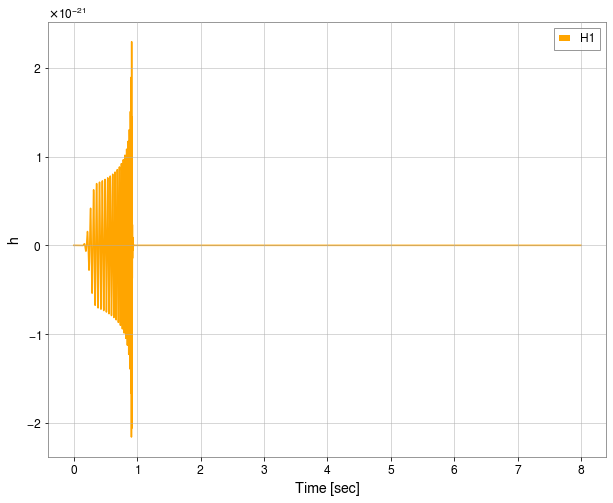

In [502]:
CompareSeries(plot_fft = False)

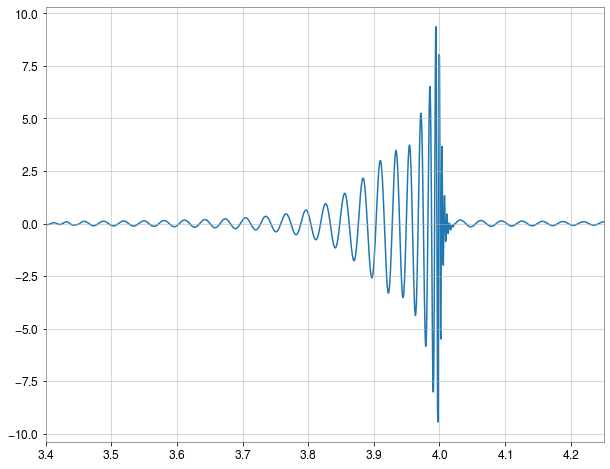

In [484]:
def GetInjectedData():
    
    f = '/home/maria.okounkova/BeyondGRAnalysis/Waveforms/dCS_0p0_Lev2/dCS_0p0_SNR_100/trigtime_1197495364.000000000_0.0_0.0_0/post/whitened_data_H1.dat'
    data = np.loadtxt(f)
    
    s_rate = 2048 # Hz
    dt = 1.0/s_rate
    time = np.array([dt * t for t in range(len(data))])
    
    plt.figure(figsize=(10,8))
    plt.plot(time, data)
    plt.xlim(3.4, 4.25)
    plt.show()

    return time, data

t, d = GetInjectedData()